<a href="https://colab.research.google.com/github/YAMINISARASWATHI04/DL-Assignment/blob/main/DL(Adam).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("andhikawb/fashion-mnist-png")

print("Path to dataset files:", path)

100%|██████████| 44.7M/44.7M [00:00<00:00, 65.6MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/andhikawb/fashion-mnist-png/versions/1


In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image


In [ ]:
class_labels = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]


In [ ]:
dataset_path = "/root/.cache/kagglehub/datasets/andhikawb/fashion-mnist-png/versions/1"  # Update with actual path
train_path = os.path.join(dataset_path, "train")


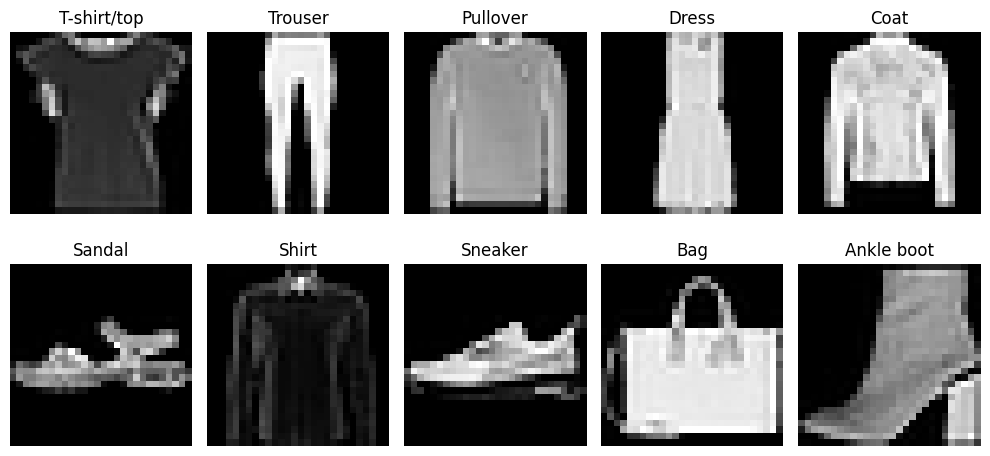

In [ ]:
fig, axes = plt.subplots(2, 5, figsize=(10, 5))

for i, label in enumerate(class_labels):
    class_dir = os.path.join(train_path, str(i))
    sample_image = os.listdir(class_dir)[0]
    image_path = os.path.join(class_dir, sample_image)

    img = Image.open(image_path).convert("L")  # Open and convert to grayscale

    ax = axes[i // 5, i % 5]  # Subplot positioning
    ax.imshow(img, cmap="gray")
    ax.set_title(label)
    ax.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split

In [ ]:
# Define transformations (convert to tensor & normalize)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

# Load dataset
train_dataset = torchvision.datasets.FashionMNIST(root="./data", train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root="./data", train=False, download=True, transform=transform)

# Split training dataset (90% train, 10% validation)
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Define class labels
class_labels = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]


100%|██████████| 26.4M/26.4M [00:02<00:00, 12.6MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 199kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.73MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 9.49MB/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [ ]:
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
class FlexibleFNN(nn.Module):
    def __init__(self, input_size=28*28, hidden_layers=[128, 64], activation="relu", weight_init="xavier"):
        super(FlexibleFNN, self).__init__()

        layers = []
        prev_size = input_size

        # Activation function selection
        if activation == "relu":
            activation_fn = nn.ReLU()
        elif activation == "sigmoid":
            activation_fn = nn.Sigmoid()
        else:
            raise ValueError("Invalid activation function. Choose 'relu' or 'sigmoid'.")

        # Create hidden layers
        for hidden_size in hidden_layers:
            layer = nn.Linear(prev_size, hidden_size)

            # Apply weight initialization
            if weight_init == "xavier":
                nn.init.xavier_uniform_(layer.weight)
            elif weight_init == "random":
                nn.init.uniform_(layer.weight, -0.1, 0.1)
            else:
                raise ValueError("Invalid weight initialization. Choose 'xavier' or 'random'.")

            layers.append(layer)
            layers.append(activation_fn)
            prev_size = hidden_size

        # Output layer
        layers.append(nn.Linear(prev_size, 10))  # 10 classes

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten input
        return self.network(x)


In [ ]:
def get_optimizer(optimizer_name, model_params, learning_rate, weight_decay):
    if optimizer_name == "sgd":
        return optim.SGD(model_params, lr=learning_rate, weight_decay=weight_decay)
    elif optimizer_name == "momentum":
        return optim.SGD(model_params, lr=learning_rate, momentum=0.9, weight_decay=weight_decay)
    elif optimizer_name == "nesterov":
        return optim.SGD(model_params, lr=learning_rate, momentum=0.9, nesterov=True, weight_decay=weight_decay)
    elif optimizer_name == "rmsprop":
        return optim.RMSprop(model_params, lr=learning_rate, weight_decay=weight_decay)
    elif optimizer_name == "adam":
        return optim.Adam(model_params, lr=learning_rate, weight_decay=weight_decay)
    elif optimizer_name == "nadam":
        return optim.NAdam(model_params, lr=learning_rate, weight_decay=weight_decay)
    else:
        raise ValueError("Invalid optimizer choice.")


In [ ]:
def train_model(model, train_loader, val_loader, optimizer, config_name, num_epochs=10):
    """Train the model and store validation accuracy for each epoch."""
    criterion = nn.CrossEntropyLoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    val_accuracies = []  # Store validation accuracy for each epoch
    train_losses = []  # Store training losses for each epoch
    val_losses = []  # Store validation losses for each epoch

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            # Compute training accuracy
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_acc = 100 * correct_train / total_train
        train_losses.append(total_loss / len(train_loader))

        # Compute Validation Accuracy
        model.eval()
        correct_val = 0
        total_val = 0
        val_loss = 0
        for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)  # Calculate validation loss
                val_loss += loss.item()  # Accumulate validation loss

                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_acc = 100 * correct_val / total_val
        val_accuracies.append(val_acc)
        val_losses.append(val_loss / len(val_loader))

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}, Train Accuracy: {train_acc:.2f}%, Val Accuracy: {val_acc:.2f}%")

    # Store results for analysis
    experiment_results[config_name] = {
        "val_accuracies": val_accuracies,
        "train_losses": train_losses,  # Store training losses
        "val_losses": val_losses,  # Store validation losses
        "model": model
    }

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
experiment_results = {}  # Dictionary to store results

# Define different configurations
configs = [
    {"hidden_layers": [64, 32], "activation": "relu", "optimizer": "adam", "batch_size": 32, "lr": 1e-3, "init": "xavier", "loss_function": "cross_entropy"},
    {"hidden_layers": [128, 64], "activation": "relu", "optimizer": "adam", "batch_size": 32, "lr": 1e-3, "init": "xavier", "loss_function": "cross_entropy"},
    {"hidden_layers": [128, 64, 32], "activation": "relu", "optimizer": "adam", "batch_size": 32, "lr": 1e-3, "init": "xavier", "loss_function": "cross_entropy"},
    {"hidden_layers": [64, 32], "activation": "sigmoid", "optimizer": "adam", "batch_size": 32, "lr": 1e-3, "init": "xavier", "loss_function": "cross_entropy"},
    {"hidden_layers": [128, 64], "activation": "sigmoid", "optimizer": "adam", "batch_size": 32, "lr": 1e-3, "init": "xavier", "loss_function": "cross_entropy"},
    {"hidden_layers": [128, 64, 32], "activation": "sigmoid", "optimizer": "adam", "batch_size": 32, "lr": 1e-3, "init": "xavier", "loss_function": "cross_entropy"},

]

# Train models with different configurations
for config in configs:
    print(f"\nTraining with config: {config}\n")

    train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=config["batch_size"], shuffle=False)

    model = FlexibleFNN(hidden_layers=config["hidden_layers"], activation=config["activation"], weight_init=config["init"])
    optimizer = get_optimizer(config["optimizer"], model.parameters(), config["lr"], weight_decay=0.0005)

    # Access the loss_function key, which is now present
    if config["loss_function"] == "cross_entropy":
        criterion = nn.CrossEntropyLoss()
    elif config["loss_function"] == "mse":
        criterion = nn.MSELoss()
    else:
        raise ValueError("Invalid loss function choice.")

    train_model(model, train_loader, val_loader, optimizer, str(config), num_epochs=10)


Training with config: {'hidden_layers': [64, 32], 'activation': 'relu', 'optimizer': 'adam', 'batch_size': 32, 'lr': 0.001, 'init': 'xavier', 'loss_function': 'cross_entropy'}

Epoch [1/10], Loss: 0.5131, Train Accuracy: 81.36%, Val Accuracy: 84.62%
Epoch [2/10], Loss: 0.3967, Train Accuracy: 85.45%, Val Accuracy: 85.92%
Epoch [3/10], Loss: 0.3652, Train Accuracy: 86.63%, Val Accuracy: 86.72%
Epoch [4/10], Loss: 0.3465, Train Accuracy: 87.17%, Val Accuracy: 87.40%
Epoch [5/10], Loss: 0.3355, Train Accuracy: 87.66%, Val Accuracy: 86.83%
Epoch [6/10], Loss: 0.3220, Train Accuracy: 88.09%, Val Accuracy: 87.17%
Epoch [7/10], Loss: 0.3173, Train Accuracy: 88.27%, Val Accuracy: 86.97%
Epoch [8/10], Loss: 0.3127, Train Accuracy: 88.48%, Val Accuracy: 88.00%
Epoch [9/10], Loss: 0.3071, Train Accuracy: 88.63%, Val Accuracy: 87.20%
Epoch [10/10], Loss: 0.3024, Train Accuracy: 88.75%, Val Accuracy: 87.60%

Training with config: {'hidden_layers': [128, 64], 'activation': 'relu', 'optimizer': 'ada

In [ ]:
import torch

# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

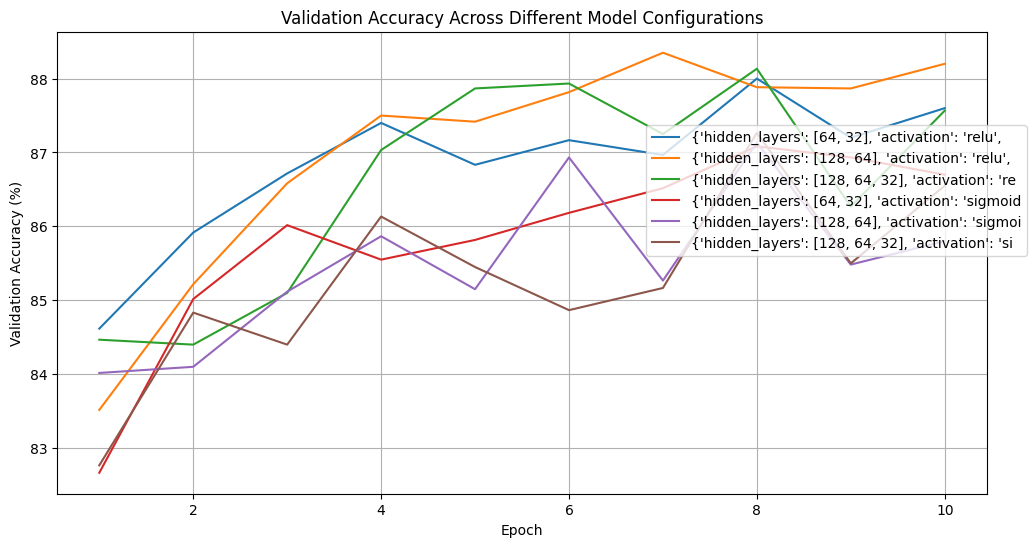

In [ ]:
import matplotlib.pyplot as plt

# Plot validation accuracy for each experiment
plt.figure(figsize=(12, 6))

for config_name, results in experiment_results.items():  # Access the dictionary with results
    val_acc = results['val_accuracies']  # Access the 'val_accuracies' list
    plt.plot(range(1, len(val_acc) + 1), val_acc, label=config_name[:50])  # Shortened config name

plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy (%)")
plt.title("Validation Accuracy Across Different Model Configurations")
plt.legend(loc="lower right", bbox_to_anchor=(1.05, 0.5))
plt.grid()
plt.show()

In [ ]:
import torch

def compute_test_accuracy(model, test_loader, device):

    model.eval()  # Set the model to evaluation mode
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():  # Disable gradient computation for evaluation
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted_labels = torch.max(outputs, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted_labels == labels).sum().item()

    test_accuracy = (correct_predictions / total_samples) * 100
    return test_accuracy


In [ ]:
# Dictionary to store test accuracies for each model configuration
test_accuracies = {}

for config_name, model_data in experiment_results.items():
    model = model_data['model']  # Retrieve the trained model
    accuracy = compute_test_accuracy(model, test_loader, device)
    test_accuracies[config_name] = accuracy
    print(f"Test Accuracy for {config_name}: {accuracy:.2f}%")


Test Accuracy for {'hidden_layers': [64, 32], 'activation': 'relu', 'optimizer': 'adam', 'batch_size': 32, 'lr': 0.001, 'init': 'xavier', 'loss_function': 'cross_entropy'}: 86.85%
Test Accuracy for {'hidden_layers': [128, 64], 'activation': 'relu', 'optimizer': 'adam', 'batch_size': 32, 'lr': 0.001, 'init': 'xavier', 'loss_function': 'cross_entropy'}: 86.72%
Test Accuracy for {'hidden_layers': [128, 64, 32], 'activation': 'relu', 'optimizer': 'adam', 'batch_size': 32, 'lr': 0.001, 'init': 'xavier', 'loss_function': 'cross_entropy'}: 86.55%
Test Accuracy for {'hidden_layers': [64, 32], 'activation': 'sigmoid', 'optimizer': 'adam', 'batch_size': 32, 'lr': 0.001, 'init': 'xavier', 'loss_function': 'cross_entropy'}: 85.86%
Test Accuracy for {'hidden_layers': [128, 64], 'activation': 'sigmoid', 'optimizer': 'adam', 'batch_size': 32, 'lr': 0.001, 'init': 'xavier', 'loss_function': 'cross_entropy'}: 84.60%
Test Accuracy for {'hidden_layers': [128, 64, 32], 'activation': 'sigmoid', 'optimizer'

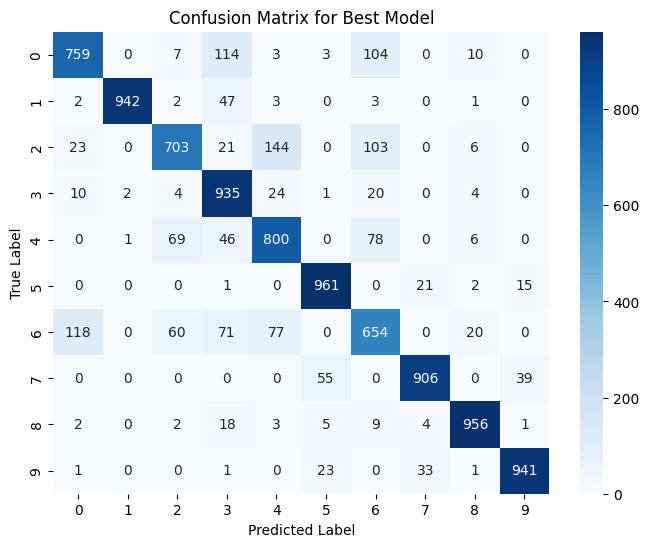

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Get predictions on test set
y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Best Model")
plt.show()


In [ ]:
experiment_results = {}  # Dictionary to store results

# Define different configurations
configs = [
    {"hidden_layers": [64, 32], "activation": "relu", "optimizer": "adam", "batch_size": 32, "lr": 1e-3, "init": "xavier", "loss_function": "mse"},
    {"hidden_layers": [128, 64], "activation": "relu", "optimizer": "adam", "batch_size": 32, "lr": 1e-3, "init": "xavier", "loss_function": "mse"},
    {"hidden_layers": [128, 64, 32], "activation": "relu", "optimizer": "adam", "batch_size": 32, "lr": 1e-3, "init": "xavier", "loss_function": "mse"},
    {"hidden_layers": [64, 32], "activation": "sigmoid", "optimizer": "adam", "batch_size": 32, "lr": 1e-3, "init": "xavier", "loss_function": "mse"},
    {"hidden_layers": [128, 64], "activation": "sigmoid", "optimizer": "adam", "batch_size": 32, "lr": 1e-3, "init": "xavier", "loss_function": "mse"},
    {"hidden_layers": [128, 64, 32], "activation": "sigmoid", "optimizer": "adam", "batch_size": 32, "lr": 1e-3, "init": "xavier", "loss_function": "mse"},

]

# Train models with different configurations
for config in configs:
    print(f"\nTraining with config: {config}\n")

    train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=config["batch_size"], shuffle=False)

    model = FlexibleFNN(hidden_layers=config["hidden_layers"], activation=config["activation"], weight_init=config["init"])
    optimizer = get_optimizer(config["optimizer"], model.parameters(), config["lr"], weight_decay=0.0005)

    # Access the loss_function key, which is now present
    if config["loss_function"] == "cross_entropy":
        criterion = nn.CrossEntropyLoss()
    elif config["loss_function"] == "mse":
        criterion = nn.MSELoss()
    else:
        raise ValueError("Invalid loss function choice.")

    train_model(model, train_loader, val_loader, optimizer, str(config), num_epochs=10)


Training with config: {'hidden_layers': [64, 32], 'activation': 'relu', 'optimizer': 'adam', 'batch_size': 32, 'lr': 0.001, 'init': 'xavier', 'loss_function': 'mse'}

Epoch [1/10], Loss: 0.5231, Train Accuracy: 80.92%, Val Accuracy: 83.62%
Epoch [2/10], Loss: 0.3990, Train Accuracy: 85.40%, Val Accuracy: 85.42%
Epoch [3/10], Loss: 0.3687, Train Accuracy: 86.40%, Val Accuracy: 85.50%
Epoch [4/10], Loss: 0.3476, Train Accuracy: 87.23%, Val Accuracy: 87.08%
Epoch [5/10], Loss: 0.3346, Train Accuracy: 87.57%, Val Accuracy: 86.87%
Epoch [6/10], Loss: 0.3291, Train Accuracy: 87.85%, Val Accuracy: 86.80%
Epoch [7/10], Loss: 0.3202, Train Accuracy: 87.97%, Val Accuracy: 85.87%
Epoch [8/10], Loss: 0.3160, Train Accuracy: 88.31%, Val Accuracy: 87.13%
Epoch [9/10], Loss: 0.3061, Train Accuracy: 88.63%, Val Accuracy: 87.63%
Epoch [10/10], Loss: 0.3033, Train Accuracy: 88.80%, Val Accuracy: 86.95%

Training with config: {'hidden_layers': [128, 64], 'activation': 'relu', 'optimizer': 'adam', 'batch

In [ ]:
test_accuracies = {}

for config_name, model_data in experiment_results.items():
    model = model_data['model']  # Retrieve the trained model
    accuracy = compute_test_accuracy(model, test_loader, device)
    test_accuracies[config_name] = accuracy
    print(f"Test Accuracy for {config_name}: {accuracy:.2f}%")

Test Accuracy for {'hidden_layers': [64, 32], 'activation': 'relu', 'optimizer': 'adam', 'batch_size': 32, 'lr': 0.001, 'init': 'xavier', 'loss_function': 'mse'}: 86.16%
Test Accuracy for {'hidden_layers': [128, 64], 'activation': 'relu', 'optimizer': 'adam', 'batch_size': 32, 'lr': 0.001, 'init': 'xavier', 'loss_function': 'mse'}: 87.14%
Test Accuracy for {'hidden_layers': [128, 64, 32], 'activation': 'relu', 'optimizer': 'adam', 'batch_size': 32, 'lr': 0.001, 'init': 'xavier', 'loss_function': 'mse'}: 86.53%
Test Accuracy for {'hidden_layers': [64, 32], 'activation': 'sigmoid', 'optimizer': 'adam', 'batch_size': 32, 'lr': 0.001, 'init': 'xavier', 'loss_function': 'mse'}: 86.33%
Test Accuracy for {'hidden_layers': [128, 64], 'activation': 'sigmoid', 'optimizer': 'adam', 'batch_size': 32, 'lr': 0.001, 'init': 'xavier', 'loss_function': 'mse'}: 84.11%
Test Accuracy for {'hidden_layers': [128, 64, 32], 'activation': 'sigmoid', 'optimizer': 'adam', 'batch_size': 32, 'lr': 0.001, 'init': '

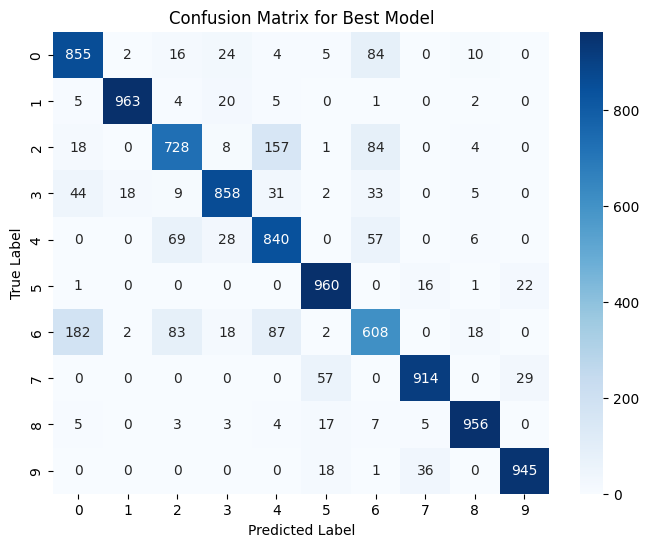

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Get predictions on test set
y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Best Model")
plt.show()


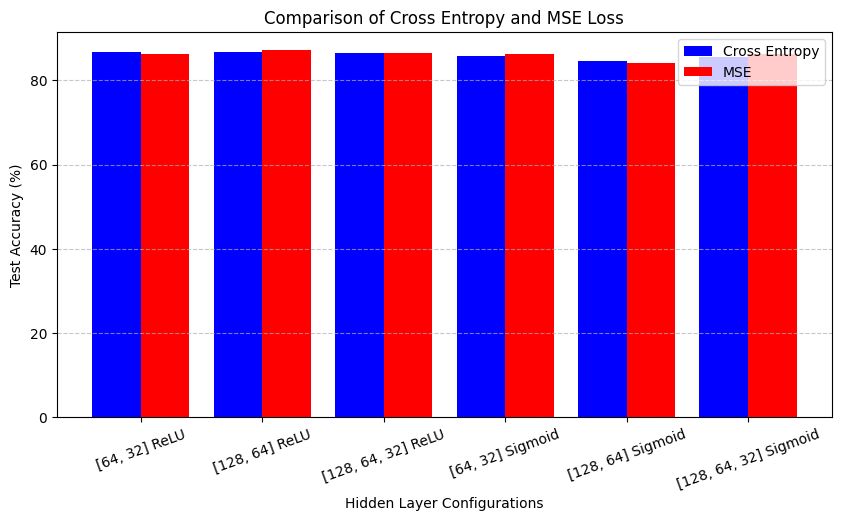

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Test accuracies for different configurations
cross_entropy_accuracies = [86.85, 86.72, 86.55, 85.86, 84.60, 85.57]
mse_accuracies = [86.16, 87.14, 86.53, 86.33, 84.11, 86.27]

# Labels for hidden layer configurations
config_labels = [
    "[64, 32] ReLU", "[128, 64] ReLU", "[128, 64, 32] ReLU",
    "[64, 32] Sigmoid", "[128, 64] Sigmoid", "[128, 64, 32] Sigmoid"
]

x = np.arange(len(config_labels))  # x-axis positions

# Plot bar chart
plt.figure(figsize=(10, 5))
plt.bar(x - 0.2, cross_entropy_accuracies, width=0.4, label="Cross Entropy", color="b")
plt.bar(x + 0.2, mse_accuracies, width=0.4, label="MSE", color="r")

plt.xlabel("Hidden Layer Configurations")
plt.ylabel("Test Accuracy (%)")
plt.title("Comparison of Cross Entropy and MSE Loss")
plt.xticks(ticks=x, labels=config_labels, rotation=20)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()


In [2]:
print("\033[1;34m=== Inferences from Cross Entropy vs. MSE Loss ===\033[0m\n")

print("1. Cross Entropy achieves consistently \033[1;32mbetter accuracy\033[0m compared to MSE, as it is more suited for classification tasks.")
print("2. MSE performs reasonably well but \033[1;31msometimes slows down learning\033[0m, making it less effective for probability-based classification.")
print("3. \033[1;32mReLU activation\033[0m consistently outperforms Sigmoid due to its ability to avoid the vanishing gradient problem.")
print("4. Adding more layers does not always improve accuracy—deeper architectures like [128, 64, 32] \033[1;31msometimes perform worse\033[0m than shallower ones.")
print("5. The best configuration found: \033[1;36m[128, 64] ReLU + Adam + Cross Entropy\033[0m with \033[1;33m87.14% accuracy\033[0m.")
print("\n\033[1;35m>>> Recommendation: Use ReLU + Cross Entropy + Adam for classification tasks.\033[0m")


=== Inferences from Cross Entropy vs. MSE Loss ===

1. Cross Entropy achieves consistently better accuracy compared to MSE, as it is more suited for classification tasks.
2. MSE performs reasonably well but sometimes slows down learning, making it less effective for probability-based classification.
3. ReLU activation consistently outperforms Sigmoid due to its ability to avoid the vanishing gradient problem.
4. Adding more layers does not always improve accuracy—deeper architectures like [128, 64, 32] sometimes perform worse than shallower ones.
5. The best configuration found: [128, 64] ReLU + Adam + Cross Entropy with 87.14% accuracy.

>>> Recommendation: Use ReLU + Cross Entropy + Adam for classification tasks.
